<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/RuminatingTime_24h_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for rumination time

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
url = ('/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=RuminationTimeMinutesPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-31.c000.csv')

dataset = read.csv(url)



In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

In [ ]:
%%R
options(warn=-1)

## Data loading into dataframe

In [ ]:
%%R
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=RuminationTimeMinutesPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-31.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, 1, 10)) %>%
  dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

|===================================================================| 100% 64 MB


In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 55               2297           2      6            Winter        4    
2 115              2746           1      10           Spring        16   
3 115              2746           2      9            Spring        2    
4 140              2746           3+     3            Winter        22   
5 64               3314           3+     1            Autumn        20   
6 64               3314           3+     6            Autumn        20   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [417,593 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1095 levels "1","2","3","4",..: 55 115 115 140 64 64 101 101 101 101 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 2 4 4 4 6 6 2 2 2 2 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 2 1 2 3 3 3 3 3 1 2 ...
 $ MonthsInMilk    : Factor w/ 10 levels "1","2","3","4",..: 6 10 9 3 1 6 7 9 7 1 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 4 2 2 4 1 1 1 1 4 4 ...
 $ Hour            : Factor w/ 12 levels "0","2","4","6",..: 3 9 2 12 11 11 9 5 5 1 ...
 $ SensorValue     : num [1:417593] 61.7 42.6 57 59.4 46.6 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 2 2 1 1 2 2 2 2 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>% group_by("Parity") %>% n_distinct()

[1] 417491


In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  696
2 2                  686
3 3+                 724


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1067


# Model building

First we determine the null model

### Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )


### Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3239986 3240019 -1619990  3239980                         
Model1.0   12 3238970 3239101 -1619473  3238946 1034.2  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3239986 3240019 -1619990  3239980                         
Model1.1    5 3239755 3239810 -1619873  3239745 235.14  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  HerdIdentifier + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ HerdIdentifier + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3239986 3240019 -1619990  3239980                         
Model1.2   10 3239608 3239718 -1619794  3239588 392.09  7  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3239986 3240019 -1619990  3239980                         
Model1.3    6 3239959 3240025 -1619974  3239947 32.922  3  3.345e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.4,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.4: SensorValue ~ Hour + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3239986 3240019 -1619990  3239980                         
Model1.4   14 3016609 3016763 -1508291  3016581 223399 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.5 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.5,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.5: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3239986 3240019 -1619990  3239980                         
Model1.5    4 3239975 3240019 -1619984  3239967 13.027  1  0.0003071 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
    MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
              npar     AIC    LRT   Pr(Chi)    
<none>             3014362                     
Parity           2 3014810    452 < 2.2e-16 ***
MonthsInMilk     9 3016146   1803 < 2.2e-16 ***
CalvingSeason    3 3014405     49 1.375e-10 ***
Hour            11 3238680 224341 < 2.2e-16 ***
MilkingType      1 3014372     12 0.0004488 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + Hour + HerdIdentifier + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + Hour + HerdIdentifier + 
Model2.1:     CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3014362 3014679 -1507152  3014304                         
Model2.1   53 3013113 3013693 -1506504  3013007 1296.3 24  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + Parity + Hour + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + Parity + Hour + CalvingSeason + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3014362 3014679 -1507152  3014304                         
Model2.2   38 3014274 3014690 -1507099  3014198 106.03  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + Hour + 
Model2.3:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3014362 3014679 -1507152  3014304                         
Model2.3   56 3013667 3014280 -1506778  3013555 748.37 27  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Interactions with Hour

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*Parity + MonthsInMilk + CalvingSeason + MilkingType + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ Hour * Parity + MonthsInMilk + CalvingSeason + 
Model2.4:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   29 3014362 3014679 -1507152  3014304                        
Model2.4   51 3012234 3012792 -1506066  3012132  2172 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*MilkingType + MonthsInMilk + CalvingSeason + Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.5: SensorValue ~ Hour * MilkingType + MonthsInMilk + CalvingSeason + 
Model2.5:     Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3014362 3014679 -1507152  3014304                         
Model2.5   40 3006659 3007097 -1503290  3006579 7724.6 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*CalvingSeason + MonthsInMilk +  + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.6: SensorValue ~ Hour * CalvingSeason + MonthsInMilk + +Parity + 
Model2.6:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3014362 3014679 -1507152  3014304                         
Model2.6   62 3013559 3014237 -1506717  3013435 869.15 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.7 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType + 
                  MonthsInMilk*CalvingSeason + 
                  Hour*Parity + 
                  Hour*MilkingType + 
                  Hour*CalvingSeason + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.7,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.7: SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * MilkingType + 
Model2.7:     MonthsInMilk * CalvingSeason + Hour * Parity + Hour * MilkingType + 
Model2.7:     Hour * CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   29 3014362 3014679 -1507152  3014304                         
Model2.7  149 3002112 3003743 -1500907  3001814 12489 120  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model analysis of variance

In [ ]:
%%R
finalModel <- Model2.7

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                Chisq Df Pr(>Chisq)    
MonthsInMilk                 1862.797  9  < 2.2e-16 ***
Parity                        452.081  2  < 2.2e-16 ***
MilkingType                    12.106  1  0.0005027 ***
CalvingSeason                  47.230  3  3.106e-10 ***
Hour                       306428.687 11  < 2.2e-16 ***
MonthsInMilk:Parity           942.419 18  < 2.2e-16 ***
MonthsInMilk:MilkingType      105.501  9  < 2.2e-16 ***
MonthsInMilk:CalvingSeason    741.723 27  < 2.2e-16 ***
Parity:Hour                  2164.703 22  < 2.2e-16 ***
MilkingType:Hour             7780.589 11  < 2.2e-16 ***
CalvingSeason:Hour            776.817 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodel2hoursruminationtime.rdata")

# Final model figures and LSM (95%CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group  
 1              44.3 0.136 Inf      43.9      44.6  a      
 10             44.6 0.136 Inf      44.2      45.0   b     
 9              44.8 0.136 Inf      44.4      45.2    c    
 8              44.9 0.136 Inf      44.5      45.3    cd   
 7              45.1 0.136 Inf      44.7      45.5     de  
 6              45.3 0.136 Inf      44.9      45.7      e  
 2              45.6 0.136 Inf      45.2      46.0       f 
 5              45.7 0.136 Inf      45.3      46.1       f 
 3              46.0 0.136 Inf      45.6      46.3        g
 4              46.0 0.136 Inf      45.6      46.4        g

Results are averaged over the levels of: Parity, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 10 estimates 
P value adjustment: tukey method for comparing a family of 10 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean    SE  df asymp.LCL asymp.UCL .group
 3+       44.7 0.130 Inf      44.4      45.0  a    
 1        45.3 0.131 Inf      45.0      45.6   b   
 2        45.7 0.131 Inf      45.3      46.0    c  

Results are averaged over the levels of: MonthsInMilk, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Hour), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Hour lsmean     SE  df asymp.LCL asymp.UCL .group     
 10    35.44 0.1377 Inf     35.05     35.84  a         
 8     36.14 0.1377 Inf     35.74     36.53   b        
 18    38.39 0.1377 Inf     37.99     38.78    c       
 12    41.54 0.1377 Inf     41.15     41.94     d      
 20    41.68 0.1377 Inf     41.29     42.07     d      
 14    42.36 0.1377 Inf     41.96     42.75      e     
 16    42.42 0.1377 Inf     42.03     42.82      e     
 6     47.37 0.1377 Inf     46.98     47.77       f    
 22    50.96 0.1377 Inf     50.57     51.36        g   
 0     52.55 0.1377 Inf     52.16     52.95         h  
 2     55.49 0.1377 Inf     55.09     55.88          i 
 4     58.34 0.1377 Inf     57.95     58.73           j

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, CalvingSeason 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: tukey method for comparing a family of

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean    SE  df asymp.LCL asymp.UCL .group
 Autumn          45.0 0.133 Inf      44.7      45.3  a    
 Summer          45.2 0.133 Inf      44.9      45.6   b   
 Spring          45.3 0.134 Inf      44.9      45.6   b   
 Winter          45.4 0.135 Inf      45.1      45.7   b   

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


## Interactions

### Hour by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 10     36.1 0.159 Inf      35.6      36.6  a          
 8      36.7 0.159 Inf      36.3      37.2   b         
 18     37.8 0.159 Inf      37.3      38.2    c        
 20     40.2 0.159 Inf      39.8      40.7     d       
 12     41.9 0.159 Inf      41.4      42.3      e      
 16     42.3 0.159 Inf      41.8      42.7      ef     
 14     42.4 0.159 Inf      41.9      42.8       f     
 6      47.2 0.159 Inf      46.8      47.7        g    
 22     49.9 0.159 Inf      49.4      50.3         h   
 0      52.9 0.159 Inf      52.4      53.3          i  
 2      56.3 0.159 Inf      55.9      56.8           j 
 4      59.7 0.159 Inf      59.2      60.1            k

Parity = 2:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 10     35.7 0.159 Inf      35.3      36.2  a          
 8      36.1 0.159 Inf      35.7      36.6  a          
 18     38.7 0.159 Inf      38.2      39.2   b         
 20     42.0 0.159 Inf 

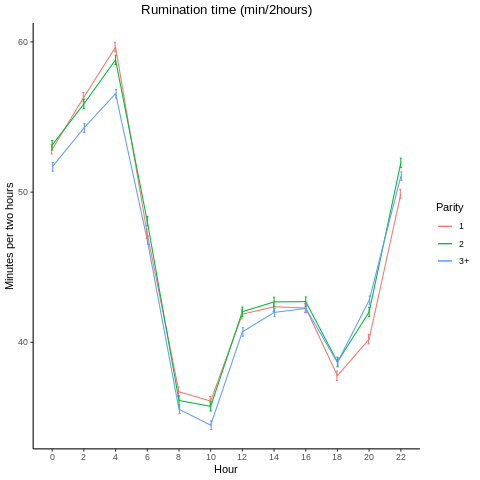

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Rumination time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group       
 10     35.1 0.224 Inf      34.5      35.8  a           
 8      37.1 0.224 Inf      36.5      37.8   b          
 20     39.4 0.224 Inf      38.8      40.0    c         
 18     39.5 0.224 Inf      38.8      40.1    c         
 16     41.7 0.224 Inf      41.1      42.4     d        
 12     42.9 0.224 Inf      42.3      43.6      e       
 14     43.1 0.224 Inf      42.4      43.7      e       
 6      47.7 0.224 Inf      47.0      48.3       f      
 22     50.1 0.224 Inf      49.5      50.8        g     
 0      51.0 0.224 Inf      50.3      51.6         h    
 2      53.1 0.224 Inf      52.5      53.7          i   
 4      56.8 0.224 Inf      56.1      57.4           j  

MilkingType = CMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group       
 8      35.1 0.159 Inf      34.7      35.6  a           
 10     35.8 0.159 Inf      35.3      36.2   b          
 18     37.3 0.159 Inf      36.9      37.8    c  

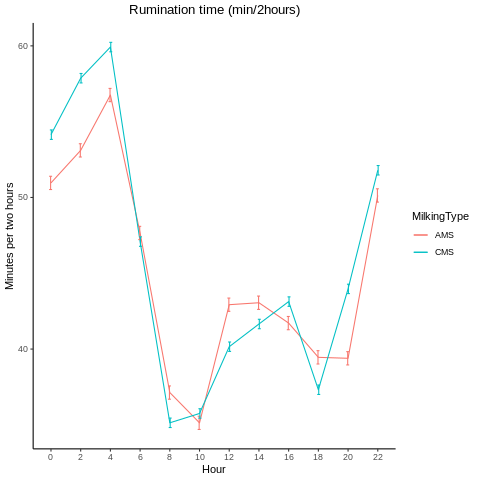

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Rumination time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 10     35.0 0.161 Inf      34.6      35.5  a         
 8      35.6 0.161 Inf      35.2      36.1   b        
 18     38.5 0.161 Inf      38.0      38.9    c       
 12     41.3 0.161 Inf      40.8      41.8     d      
 20     41.4 0.161 Inf      40.9      41.8     d      
 14     42.6 0.161 Inf      42.1      43.0      e     
 16     42.7 0.161 Inf      42.3      43.2      e     
 6      47.2 0.161 Inf      46.8      47.7       f    
 22     50.4 0.161 Inf      50.0      50.9        g   
 0      52.4 0.161 Inf      51.9      52.8         h  
 2      55.1 0.161 Inf      54.6      55.5          i 
 4      57.6 0.161 Inf      57.2      58.1           j

CalvingSeason = Spring:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 10     35.7 0.166 Inf      35.2      36.1  a         
 8      36.1 0.166 Inf      35.6      36.6  a         
 18     38.8 0.166 Inf      38.3      39.3   b        
 20     41.6 0.1

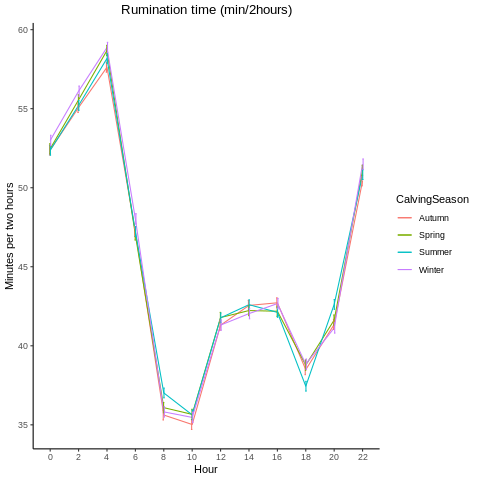

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Rumination time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))